# Matching GPX to OSM data

Importing packages

In [127]:
from shapely.geometry import Point, LineString
import numpy as np
import rasterio
from rtree import index
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs
import xml.etree.ElementTree as ET
import gpxpy.gpx
from pyproj import CRS
from pyproj import Transformer

Importing the network

In [128]:
sheepstor_map = rasterio.open(
        os.path.join('OS Explorer Maps', 'Download_South+Dartmoor_2004150', 'raster-25k_4541337', 'sx', 'sx56.tif'))

path_network = gpd.read_file(os.path.join('Detailed-Path-Network', 'DARTMOOR NATIONAL PARK.gml'))

tree = ET.parse(os.path.join('Detailed-Path-Network', 'DARTMOOR NATIONAL PARK.gml'))

Importing the gpx data

In [129]:
gpx_file = open(os.path.join('Walking routes', 'Bluebell walk.gpx'), 'r')

Creating the Network

In [130]:
def create_network(gml, gml_gpd):
    root = gml.getroot()
    startnodes = [startNode.attrib for startNode in
                  root.iter('{http://namespaces.os.uk/networks/detailedPathNetwork/1.0}startNode')]
    gml_gpd['startNodes'] = [nodes['{http://www.w3.org/1999/xlink}href'] for nodes in startnodes]
    endnodes = [endNode.attrib for endNode in
                root.iter('{http://namespaces.os.uk/networks/detailedPathNetwork/1.0}endNode')]
    gml_gpd['endNodes'] = [nodes['{http://www.w3.org/1999/xlink}href'] for nodes in endnodes]

    nodes_id = [nodes.attrib for nodes in
                root.iter('{http://namespaces.os.uk/networks/detailedPathNetwork/1.0}RouteNode')]
    node_ids = [node['{http://www.opengis.net/gml/3.2}id'] for node in nodes_id]

    network_coords = [geom.text for geom in root.iter('{http://www.opengis.net/gml/3.2}pos')]
    node_coordinates = []
    for i in network_coords:
        coords = i.split(" ")
        coords = [float(j) for j in coords]
        node_coordinates.append(coords)

    node_geom = [Point(node) for node in node_coordinates]

    network_nodes = gpd.GeoDataFrame({'fid': nodes_id, 'geometry': node_geom})

    graph = nx.Graph()
    for index, row in gml_gpd.iterrows():
        graph.add_edge(row['startNodes'], row['endNodes'], fid=row['gml_id'], weight=row['planimetricLength'])

    return graph, network_nodes


In [131]:
g, path_nodes = create_network(tree, path_network)

Create the index

In [132]:
def create_index(network_nodes):
    idx = index.Index()
    # set the bounds for the index
    for i in range(len(network_nodes['fid'])):
        left, bottom, right, top = (network_nodes['geometry'][i].x, network_nodes['geometry'][i].y,
                                    network_nodes['geometry'][i].x, network_nodes['geometry'][i].y)
        idx.insert(i, (left, bottom, right, top))
    return idx

In [133]:
idx = create_index(path_nodes)

Converting the gpx data

In [134]:
def import_gpx(gpx_file):
    gpx = gpxpy.parse(gpx_file)

    wsg84 = CRS.from_epsg(4326)
    osgb36 = CRS.from_epsg(27700)
    transformer = Transformer.from_crs(wsg84, osgb36)

    points = []
    if gpx.waypoints:
        waypoints = gpx.waypoints
    else:
        routes = gpx.routes
        waypoints = routes[0].points

    for waypoint in waypoints:
        points.append(transformer.transform(waypoint.latitude, waypoint.longitude))

    route_gpd = gpd.GeoSeries(LineString(points))
    # route_gpd.plot()

    bounds = []
    for bound in gpx.bounds:
        bounds.append(bound)
    top_right = (transformer.transform(bounds[1], bounds[3]))
    bottom_left = (transformer.transform(bounds[0], bounds[2]))

    return route_gpd, points, top_right, bottom_left

In [135]:
bluebell_walk, coords, top_right, bottom_left = import_gpx(gpx_file)

Finding the nearest nodes

In [136]:
def get_nearest_nodes(idx, network_nodes, first_point, point, global_nodes, global_missing_links):
    for i in idx.nearest(first_point, 1):
        first_coordinate = network_nodes['geometry'][i]
        # need to add # so that it is identified in with the link
        first_node = ("#" + network_nodes['fid'][i].get('{http://www.opengis.net/gml/3.2}id'))
        global_nodes.append(first_coordinate)
    for i in idx.nearest(point, 1):
        last_coordinate = network_nodes['geometry'][i]
        # need to add # so that it is identified in with the link
        last_node = ("#" + network_nodes['fid'][i].get('{http://www.opengis.net/gml/3.2}id'))
        global_nodes.append(last_coordinate)

    def calculate_hausdorff_distances():
        far_nearest_gpx = []
        far_nearest_node = []
        gpx_start = Point(first_point)
        node_start = Point(first_coordinate)
        print("Start point", gpx_start.hausdorff_distance(node_start))
        start_distance = gpx_start.hausdorff_distance(node_start)
        # if gpx_start.hausdorff_distance(node_start) > 50:
        #     far_nearest_gpx.append(gpx_start)
        #     far_nearest_node.append(node_start)
        gpx_end = Point(point)
        node_end = Point(last_coordinate)
        print("End point", gpx_end.hausdorff_distance(node_end))
        end_distance = gpx_end.hausdorff_distance(node_end)
        # if gpx_start.hausdorff_distance(node_start) > 50:
        #     far_nearest_gpx.append(gpx_end)
        #     far_nearest_node.append(node_end)
        return start_distance,end_distance

    start_distance,end_distance = calculate_hausdorff_distances()

    if first_coordinate == last_coordinate:
    #if first_coordinate == last_coordinate or( start_distance or end_distance > 240) :
        # print('Same node')
        # plt.plot(LineString(zip(first_point, point)))
        global_missing_links.append(LineString([first_point, point]))
    elif start_distance > 240 or end_distance > 240:
        print("Distance is greater then 240 meters")
        global_missing_links.append(LineString([first_point, point]))

    return first_coordinate, first_node, last_coordinate, last_node

Converting gpx to path

In [137]:
def gpx_to_path(first_node, last_node, g, path_network, global_geom, global_links):
    path = nx.dijkstra_path(g, first_node, last_node, weight='weight')
    if len(path) != 1:
        geom = []
        links = []

        first_node = path[0]
        for node in path[1:]:
            link_fid = g.edges[first_node, node]['fid']
            links.append(link_fid)
            global_links.append(link_fid)
            row = path_network.loc[path_network['gml_id'] == link_fid]
            geom.append(row['geometry'].cascaded_union)
            global_geom.append(row['geometry'].cascaded_union)
            first_node = node

        path_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})
        # print('Plotting Path')
        # path_gpd.plot()
        return path_gpd

In [138]:
def plot_map(sheepstor_map, first_coordinate, last_coordinate, first_point,point,
             bluebell_walk, path_network, path_nodes, path_gpd):
    back_array = sheepstor_map.read(1)
    palette = np.array([value for key, value in sheepstor_map.colormap(1).items()])
    background_image = palette[back_array]
    bounds = sheepstor_map.bounds
    extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
    fig = plt.figure(figsize=(3, 3), dpi=500)
    ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())
    ax.imshow(background_image, origin='upper', extent=extent, zorder=0)
    plt.scatter(first_coordinate.bounds[0], first_coordinate.bounds[1], color='yellow', s=1, zorder=6)
    plt.scatter(last_coordinate.bounds[0], last_coordinate.bounds[1], color='yellow', s=1, zorder=6)

    bluebell_walk.plot(ax=ax, edgecolor='red', linewidth=0.5, zorder=2)
    plt.scatter(first_point[0], first_point[1], color='red', s=1, zorder=3)
    plt.scatter(point[0], point[1], color='red', s=1, zorder=3)

    path_network.plot(ax=ax, edgecolor='blue', linewidth=0.5, zorder=4)
    path_nodes.plot(ax=ax, color='blue', markersize=1, zorder=4)

    path_gpd.plot(ax=ax, edgecolor='green', linewidth=2, zorder=5)
    display_extent = ((first_coordinate.bounds[0] - 500, first_coordinate.bounds[0] + 500,
                       first_coordinate.bounds[1] - 500, first_coordinate.bounds[1] + 500))
    ax.set_extent(display_extent, crs=crs.OSGB())
    plt.show()

In [139]:
global_geom = []
global_links = []
global_nodes = []
global_missing_links = []
start_point = coords[0]
for coord in coords[1:]:
    first_coordinate, first_node, last_coordinate, last_node = get_nearest_nodes(
                                                                                 idx, path_nodes, start_point, coord, global_nodes,
                                                                                 global_missing_links)
    path_gpd = gpx_to_path(first_node, last_node, g, path_network, global_geom, global_links)
    # if first_coordinate != last_coordinate:
    #     plot_map(sheepstor_map, first_coordinate, last_coordinate, start_point,coord,
    #          bluebell_walk, path_network, path_nodes, path_gpd)
    # else:
    #     print('Start and End node are the same')
    start_point = coord
global_path_gpd = gpd.GeoDataFrame({'fid': global_links, 'geometry': global_geom})
#global_path_gpd.to_file("Blubell_walk_gpd")
global_nodes_gpd = gpd.GeoDataFrame({'geometry': global_nodes})

Start point 22.16017773596072
End point 24.37708887190149
Start point 24.37708887190149
End point 14.696170501570304
Start point 14.696170501570304
End point 110.98985407386684
Start point 110.98985407386684
End point 18.821109941621362
Start point 18.821109941621362
End point 226.45081668933304
Start point 226.45081668933304
End point 21.569684454113492
Start point 21.569684454113492
End point 30.52308191429861
Start point 30.52308191429861
End point 78.45609238757199
Start point 78.45609238757199
End point 49.344561883037485
Start point 49.344561883037485
End point 166.49394960080514
Start point 166.49394960080514
End point 258.15590697032314
Distance is greater then 240 meters
Start point 258.15590697032314
End point 157.75593440965758
Start point 157.75593440965758
End point 141.65019041637896
Start point 141.65019041637896
End point 48.63272286493773
Start point 48.63272286493773
End point 122.94435457247963
Start point 122.94435457247963
End point 48.967600741802634
Start point 4

Finding the missing sections

In [140]:
def calculate_missing_sections(global_missing_links, path_gpd, points):
    missing_links = []
    path_geoseries = gpd.GeoSeries(path_gpd['geometry'])
    # account for missing nodes that are on the path due to being so small there nodes were the same
    for link in global_missing_links:
        if not any(path_geoseries.intersects(link)):

            missing_links.append(link)
    # global_missing_links_gpd = gpd.GeoSeries(global_missing_links)
    global_missing_links_gpd = gpd.GeoSeries(missing_links)
    # global_missing_links_gpd.to_file("global_missing_links_gpd")

    missing_length = ((len(global_missing_links_gpd) / (len(points) - 1))*100)
    print("Percentage of Path missing in network is", missing_length, "%")

    return global_missing_links_gpd

In [141]:
global_missing_links_gpd = calculate_missing_sections(global_missing_links, global_path_gpd, coords)

Percentage of Path missing in network is 16.0 %


Plot missing links

<AxesSubplot:>

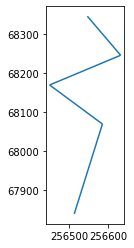

In [142]:
global_missing_links_gpd.plot()

Plot new path

In [28]:
def plot_global_map(raster_map, global_nodes_gpd, points,
                    route_gpd, path_network, path_nodes, path_gpd, top_right, bottom_left, global_missing_links_gpd):
    back_array = raster_map.read(1)
    palette = np.array([value for key, value in raster_map.colormap(1).items()])
    background_image = palette[back_array]
    bounds = raster_map.bounds
    extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
    fig = plt.figure(figsize=(3, 3), dpi=500)

    ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())
    ax.imshow(background_image, origin='upper', extent=extent, zorder=0)
    route_gpd.plot(ax=ax, edgecolor='blue', linewidth=0.5, zorder=2)
    plt.scatter(*zip(*points), color='blue', s=1, zorder=3)

    # path_network.plot(ax=ax, edgecolor='blue', linewidth=0.5, zorder=4)
    # path_nodes.plot(ax=ax, color='blue', markersize=1, zorder=4)

    global_missing_links_gpd.plot(ax=ax, color='red', linewidth=1, zorder=6)

    path_gpd.plot(ax=ax, edgecolor='green', linewidth=1, zorder=5)
    global_nodes_gpd.plot(ax=ax, color='yellow', markersize=1, zorder=5)

    display_extent = ((bottom_left[0] - 100, top_right[0] + 100,
                       bottom_left[1] - 100, top_right[1] + 100))
    ax.set_extent(display_extent, crs=crs.OSGB())
    plt.show()

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:25: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


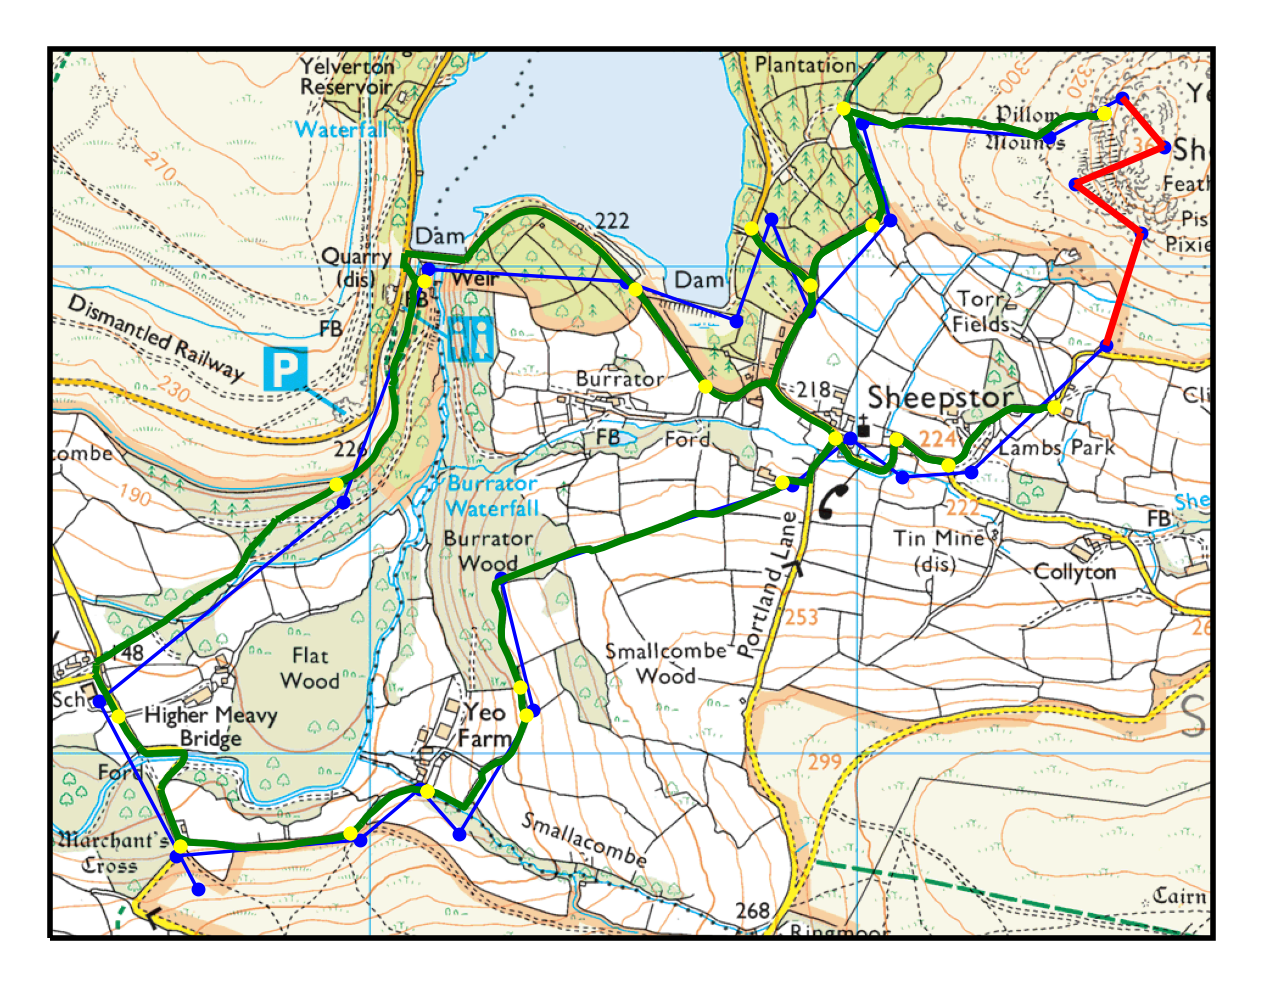

In [143]:
plot_global_map(sheepstor_map, global_nodes_gpd, coords,
                    bluebell_walk, path_network, path_nodes, global_path_gpd, top_right, bottom_left,
                    global_missing_links_gpd)